1. Importação das bibliotecas

In [1]:
import cv2
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Activation, Add, Input, AveragePooling2D
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

import numpy as np
import os, sys
from scipy import ndimage
import cv2
import matplotlib.pyplot as plt
import itertools
import scipy.stats
import tensorflow as tf
from keras import applications, optimizers, Input
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels


2. Carregando o dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
folder='/content/drive/MyDrive/dataset/dataset'

3. Estruturando o dataset

In [4]:
#image resolution
image_width = 48
image_height = 48
channels = 3 #rgb

train_files = []
i=0
for classes in ['Positive', 'Negative']:
    print(os.path.join(folder, classes))
    onlyfiles = [f for f in os.listdir(os.path.join(folder, classes)) if os.path.isfile(os.path.join(folder, classes, f ))]
    for _file in onlyfiles:
        train_files.append(_file)

dataset = np.ndarray(shape=(len(train_files), image_height, image_width, channels),
                     dtype=np.float32)
y_dataset = []

/content/drive/MyDrive/dataset/dataset/Positive
/content/drive/MyDrive/dataset/dataset/Negative


In [5]:
i = 0
for classes in ['Positive', 'Negative']:
    onlyfiles = [f for f in os.listdir(os.path.join(folder, classes)) if os.path.isfile(os.path.join(folder, classes, f))]
    for _file in onlyfiles:
        img_path = os.path.join(folder, classes, _file)
        img = load_img(img_path, target_size=(image_height, image_width))
        x = img_to_array(img)
        dataset[i] = x
        mapping = {'Positive': 0 , 'Negative' : 1}
        y_dataset.append(mapping[classes])
        i += 1
        if i == 30000:
            print("%d images to array" % i)
            break

print("All images to array!")

All images to array!


6. Normalizando os dados

In [6]:
#Normalização
dataset = dataset.astype('float32')
dataset /= 255

In [7]:
classes = ['Positive', 'Negative']

# Dicionário para armazenar o índice da primeira imagem de cada classe
first_image_index = {}

# Encontra o índice da primeira imagem de cada classe
for i, label in enumerate(y_dataset):
    if label not in first_image_index:
        first_image_index[label] = i

# Configura a grade para exibir as imagens
num_classes = len(set(y_dataset))
num_images_per_class = 1
num_cols = num_classes
num_rows = num_images_per_class

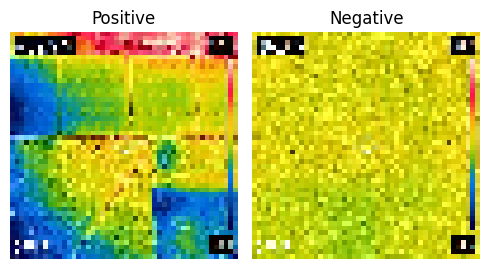

In [8]:
# Cria uma figura com uma grade de subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 5))

# Loop através de cada classe
for i in range(num_classes):
    # Obtém o índice da primeira imagem da classe
    idx = first_image_index[i]

    # Obtém a imagem e converte para RGB
    pixels = dataset[idx]

    # Exibe a imagem no subplot correspondente
    axes[i].imshow(pixels, cmap='Spectral')
    axes[i].axis('off')

    # Adiciona um título para o subplot com o rótulo
    axes[i].set_title(f'{classes[i]}')

# Exibe a figura
plt.tight_layout()
plt.show()

7. Normalizando o dataset

In [9]:
# categorical values
n_classes = len(set(y_dataset))
print(n_classes)

y_dataset_ = to_categorical(y_dataset, n_classes)

2


In [10]:
# Trim dataset to match the size of y_dataset_
dataset_trimmed = dataset[:len(y_dataset_)]

# Now both dataset_trimmed and y_dataset_ have the same size
# You can then proceed with splitting or any other operations

# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(dataset_trimmed, y_dataset_, test_size=0.2)

print("Train set size: {0}, Test set size: {1}".format(len(X_train), len(X_test)))

Train set size: 130, Test set size: 33


In [11]:
from sklearn.utils import resample

# Criar listas vazias para armazenar as amostras balanceadas
balanced_X_train = []
balanced_y_train = []

# Determinar o número de amostras na classe majoritária
majority_samples = 7000

# Iterar sobre cada classe
for class_label in np.unique(y_train.argmax(axis=1)):
    # Filtrar amostras pertencentes a essa classe
    X_class = X_train[y_train.argmax(axis=1) == class_label]
    y_class = y_train[y_train.argmax(axis=1) == class_label]

    # Calcular o número de amostras na classe menos representada
    minority_samples = len(X_class)

    # Balancear as amostras aumentando a classe menos representada
    balanced_X_class, balanced_y_class = resample(X_class, y_class,
                                                  replace=True,
                                                  n_samples=majority_samples,
                                                  random_state=42)

    # Adicionar amostras balanceadas à lista
    balanced_X_train.extend(balanced_X_class)
    balanced_y_train.extend(balanced_y_class)

# Converter listas em arrays numpy
balanced_X_train = np.array(balanced_X_train)
balanced_y_train = np.array(balanced_y_train)

# Embaralhar amostras
shuffled_indices = np.arange(len(balanced_X_train))
np.random.shuffle(shuffled_indices)
balanced_X_train = balanced_X_train[shuffled_indices]
balanced_y_train = balanced_y_train[shuffled_indices]

# Verificar o tamanho dos conjuntos de dados balanceados
print("Tamanho do conjunto de treinamento balanceado:", len(balanced_X_train))
print("Tamanho do conjunto de teste:", len(X_test))

for class_label in np.unique(balanced_y_train.argmax(axis=1)):
    count = np.sum(balanced_y_train.argmax(axis=1) == class_label)
    print(f"Classe {class_label}: {count} amostras")

Tamanho do conjunto de treinamento balanceado: 14000
Tamanho do conjunto de teste: 33
Classe 0: 7000 amostras
Classe 1: 7000 amostras


In [12]:
# Criar o modelo
model = Sequential()

model.add(BatchNormalization(input_shape=(image_height, image_width, 3)))
model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))  # Adiciona a camada de dropout

model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))  # Adiciona a camada de dropout

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))  # Adiciona a camada de dropout
model.add(Dense(2, activation='softmax'))  # Especifica 'softmax' como a função de ativação

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 48, 48, 3)           │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 48, 48, 512)         │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │       1,179,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,373,998 (9.06 MB)

 Trainable params: 2,373,992 (9.06 MB)

 Non-trainable params: 6 (24.00 B)

4. Compilando o modelo

In [13]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Treinando o modelo
from tensorflow.keras.callbacks import EarlyStopping

# Configurar EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# Treinar o modelo
history = model.fit(balanced_X_train, balanced_y_train,validation_split= 0.2, epochs=1, callbacks=[early_stopping], batch_size=64)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1478s 8s/step - accuracy: 0.8489 - loss: 0.3662 - val_accuracy: 0.9479 - val_loss: 0.1197


In [16]:
val_accuracy = history.history['val_accuracy']

mean_val_accuracy = np.mean(val_accuracy)

print("Valor médio de acurácia:", mean_val_accuracy)

Valor médio de acurácia: 0.947857141494751


5. Carregando o modelo

In [17]:
import pandas as pd
history_save = pd.DataFrame(history.history)
history_save.to_csv('datasetNormal.csv')

In [18]:
# save model structure in jason file
model_json = model.to_json()
with open("emotion_model.json", "w") as json_file:
    json_file.write(model_json)

In [19]:
model.save('modelosalvo.keras')


In [20]:
from keras.models import load_model

modelo_carregado = load_model('/content/modelosalvo.keras')

In [21]:
import pandas as pd

history = pd.read_csv('/content/datasetNormal.csv')

6. Plotando o modelo

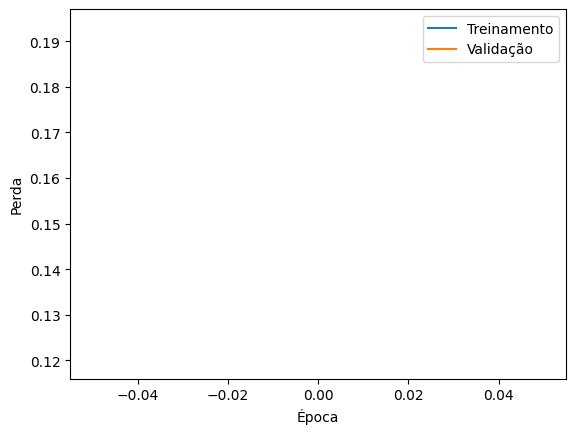

In [22]:
import matplotlib.pyplot as plt

plt.plot(history['loss'])
plt.plot(history['val_loss'])


plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['Treinamento', 'Validação'], loc = 'upper right')
plt.show()

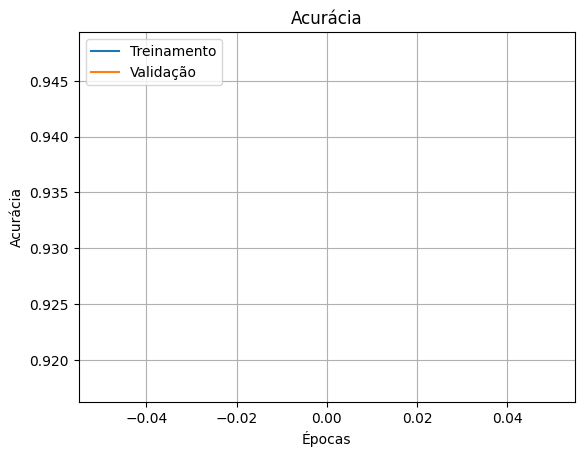

In [23]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.grid(True)
plt.show()
plt.close()

7. Salvando o modelo

In [24]:
preds = modelo_carregado.predict(X_test)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step


In [25]:
#Função da Matriz de Confusão

def plot_confusion_matrix(
        cm,
        classes,
        normalize=False,
        title='Confusion matrix',
        cmap=plt.cm.Blues
    ):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe real')
    plt.xlabel('Classe predita')

Confusion matrix, without normalization
[[19  8]
 [ 4  2]]


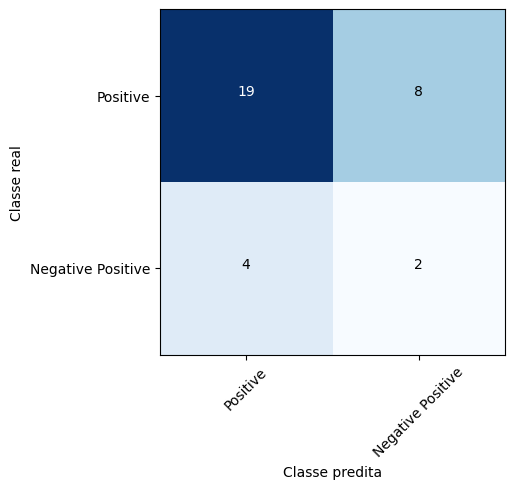

In [26]:
#Gráfico da Matriz de Confusão

y_test_ = [np.argmax(x) for x in y_test]
preds_ = [np.argmax(x) for x in preds]

cm = confusion_matrix(y_test_, preds_)
plot_confusion_matrix(cm, classes=['Positive', 'Negative Positive'], title='Confusion matrix')
plt.show()
plt.close()

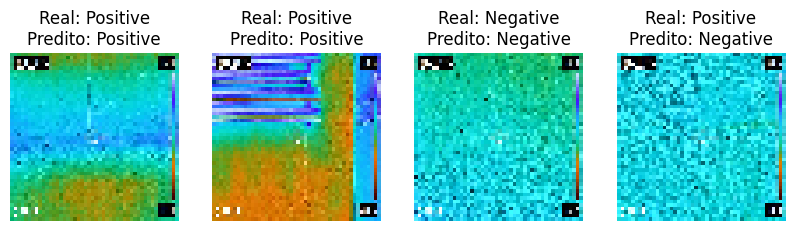

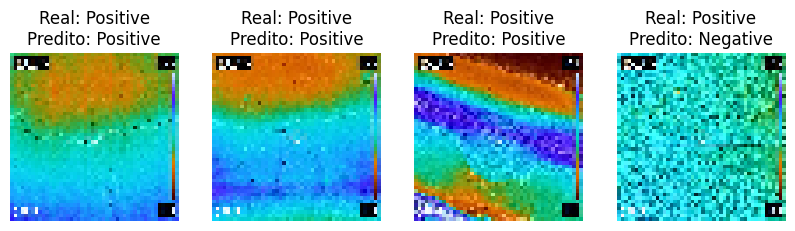

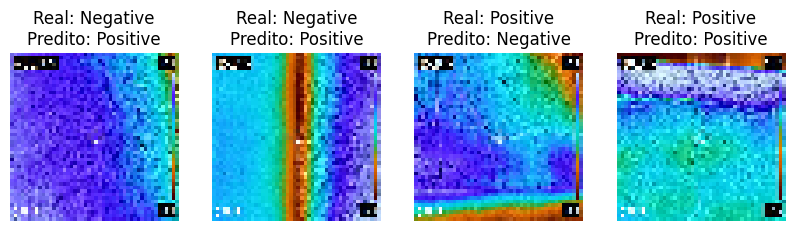

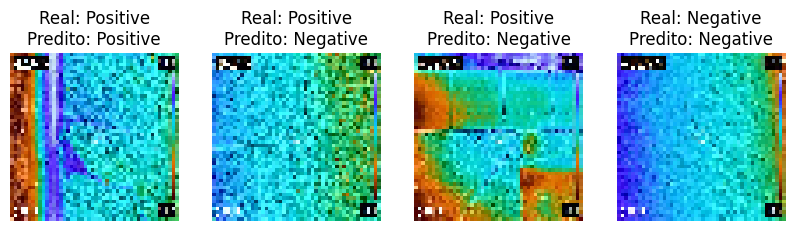

In [27]:
#Resultado das predições

n = 4
for t in range(4):
    plt.figure(figsize=(10,10))
    for i in range(n*t, n*(t+1)):
        plt.subplot(1, n, i + 1 - n*t)
        plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB), cmap='gray')
        plt.title('Real: {}\nPredito: {}'.format(classes[np.argmax(y_test[i])], classes[np.argmax(preds[i])]))
        plt.axis('off')
    plt.show()